# GHCN Data - Code to analyze Volatility of Daily Max Temperature 

### Mohammed Ombadi (2022), ombadi@lbl.gov
### Ref: https://doi.org/10.1016/j.wace.2022.100515
### If you use part or all of this code, please cite the following article: Ombadi, M. & Risser, M. (2022). What's the temperature tomorrow? Increasing trends in extreme volatility of daily maximum temperature in Central and Eastern United States (1950–2019). Weather and Climate Extremes. https://doi.org/10.1016/j.wace.2022.100515

## 1: Import Libraries

In [1]:
import os
import glob 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from datetime import datetime
import cartopy
import cartopy.crs as crs
import cartopy.feature as cfeature
import pymannkendall as mk
import scipy as sc
import cartopy
import cartopy.crs as crs
import cartopy.feature as cfeature
import math
import seaborn as sns
%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn

## 2: Import data

In [ ]:
# Import GHCNd data (1950 - 2019) for Tmax (Daily Max temperature) in the format as shown below.
# The data can be obtained from https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/

In [3]:
# Extract year, month and day from date
tmax['year'] = np.nan
tmax['month'] = np.nan
tmax['day'] = np.nan
for i in range(len(tmax)):
    tmax['year'][i] = datetime.strptime(tmax.index[i], '%Y-%m-%d').year
    tmax['month'][i] = datetime.strptime(tmax.index[i], '%Y-%m-%d').month
    tmax['day'][i] = datetime.strptime(tmax.index[i], '%Y-%m-%d').day

In [5]:
tmax

stationID,USC00010008,USC00010063,USC00010071,USC00010117,USC00010125,USC00010140,USC00010148,USC00010160,USC00010163,USC00010178,...,USC00489800,USC00489805,USC00489880,USC00489900,USC00489902,USC00489905,USC00489925,year,month,day
time,,,,,,,,,,,,,,,,,,,,,
1950-1-1,NaN,NaN,NaN,NaN,NaN,NaN,16.7,NaN,15.6,NaN,...,NaN,NaN,NaN,NaN,NaN,1.7,13.3,1950.0,1.0,1.0
1950-1-2,NaN,NaN,NaN,NaN,NaN,NaN,18.3,NaN,21.1,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.6,10.0,1950.0,1.0,2.0
1950-1-3,NaN,NaN,NaN,NaN,NaN,NaN,17.2,NaN,20.6,NaN,...,NaN,NaN,NaN,NaN,NaN,-16.7,-13.9,1950.0,1.0,3.0
1950-1-4,NaN,NaN,NaN,NaN,NaN,NaN,20.0,NaN,22.8,NaN,...,NaN,NaN,NaN,NaN,NaN,-12.2,-4.4,1950.0,1.0,4.0
1950-1-5,NaN,NaN,NaN,NaN,NaN,NaN,22.2,NaN,23.3,NaN,...,NaN,NaN,NaN,NaN,NaN,-16.1,-2.2,1950.0,1.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.9,NaN,18.9,...,NaN,0.0,NaN,NaN,-4.4,-2.2,NaN,2019.0,12.0,27.0
2019-12-28,NaN,18.3,NaN,NaN,NaN,NaN,NaN,16.1,NaN,16.7,...,NaN,3.3,NaN,NaN,-4.4,-2.2,NaN,2019.0,12.0,28.0
2019-12-29,NaN,18.3,NaN,NaN,NaN,NaN,NaN,18.3,NaN,19.4,...,NaN,-3.9,NaN,NaN,NaN,-3.9,NaN,2019.0,12.0,29.0


## 3: Compute volatility, timing and directionality

In [5]:
volatility_raw = tmax.iloc[1:,:-4].to_numpy() - tmax.iloc[:-1,:-4].to_numpy()
volatility_raw = pd.DataFrame(volatility_raw, columns= tmax.columns[:-4])
timeinfo_new = timestamp['time'][25569:51135]
timeinfo_new.index = list(range(timeinfo_new.shape[0]))
volatility_raw = pd.concat([timeinfo_new, volatility_raw], axis= 1)
year_t = tmax['year'].iloc[1:]
year_t.index = range(len(year_t))
volatility_raw = pd.concat([year_t, volatility_raw], axis= 1)

volatility_abs = abs(tmax.iloc[1:,:-4].to_numpy() - tmax.iloc[:-1,:-4].to_numpy())
volatility_abs = pd.DataFrame(volatility_abs, columns= tmax.columns[:-4])
volatility_abs = pd.concat([timeinfo_new, volatility_abs], axis= 1)
year_t = tmax['year'].iloc[1:]
year_t.index = range(len(year_t))
volatility_abs = pd.concat([year_t, volatility_abs], axis= 1)

In [7]:
pd.options.mode.chained_assignment = None  # default='warn'

years= np.arange(1950, 2020)
volatility_95p= pd.DataFrame(index= years, columns= tmax.columns[:-4])
volatility_dir= pd.DataFrame(index= years, columns= tmax.columns[:-4])
#julian_day= pd.DataFrame(index= years, columns= tmax.columns[:-4])

for i in range(len(years)):
    dummy = volatility_abs[volatility_abs['year']==years[i]]
    dummy = dummy.iloc[:,2:]
    missing = np.sum(dummy.isna(), axis= 0)
    # Exclude from calculations all stations that have more than 18 days (5%) of missing data for that specific year
    dummy = dummy.iloc[:, pd.Series(missing < 18).values]
    volatility_95p.iloc[i, pd.Series(missing < 18).values] = np.nanpercentile(dummy.to_numpy(), 95, axis= 0).flatten()
    dummy.index = list(range(len(dummy)))
    #julian_day.iloc[i, pd.Series(missing < 18).values] = dummy.idxmax(axis=0)

    dummy = volatility_raw[volatility_raw['year']==years[i]]
    dummy = dummy.iloc[:,2:]
    missing = np.sum(dummy.isna(), axis= 0)
    # Exclude from calculations all stations that have more than 18 days (5%) of missing data for that specific year
    dummy = dummy.iloc[:, pd.Series(missing < 18).values]
    d = pd.DataFrame(index= list(range(math.ceil(len(dummy)/20))), columns= dummy.columns)
    for j in range(dummy.shape[1]):
        x = dummy.iloc[:,j]
        y = x[abs(x) > np.nanpercentile(abs(x).to_numpy(), 95)]
        d.iloc[0:len(y),j] = y
        
    volatility_dir.iloc[i,pd.Series(missing < 18).values] = np.sum(d > 0, axis=0)/d.shape[0]

# Keep only stations that have at least 50 years of data or more (i.e. missing < 20)
missing = np.sum(volatility_95p.isna(), axis=0)
volatility_95p = volatility_95p.iloc[:, pd.Series(missing < 20).values]
#julian_day = julian_day.iloc[:, pd.Series(missing < 20).values]
volatility_dir = volatility_dir.iloc[:, pd.Series(missing < 20).values]

In [8]:
volatility_abs['day'] = np.nan
volatility_abs['month'] = np.nan

for i in range(len(volatility_abs)):
    volatility_abs['month'].iloc[i] = datetime.strptime(volatility_abs.time.iloc[i], '%Y-%m-%d').month
    volatility_abs['day'].iloc[i] = datetime.strptime(volatility_abs.time.iloc[i], '%Y-%m-%d').day
    
dummy = volatility_abs.iloc[:,1:].groupby(['month','day']).mean()
dummy = dummy[dummy.columns.intersection(volatility_95p.columns)]
dummy.index = list(range(dummy.shape[0]))
julian_day = dummy.idxmax(axis=0)
julian_day = pd.DataFrame(julian_day)
julian_day['stationID'] = julian_day.index
julian_day = julian_day.rename(columns={0: "julian_day"})

# Add station Information (lat, lon ...et.)
stations1 = pd.read_csv('.../stationInfo1_1880_2020.csv')
stations2 = pd.read_csv('.../stationInfo2_1880_2020.csv')
stations = pd.concat([stations1, stations2])
stations[stations['stationID'].isin(julian_day.index)]
julian_day = julian_day.merge(stations, on='stationID')

## 4: Save results dataframes

In [9]:
# This dataframe contains the 95th percentile value of volatility in daily maximum temperature for each year (1950 - 2019)
# Size of data frame is 70 years * 1484 stations
volatility_95p.to_csv('.../Results/GHCN_volatility_95p.csv')
# This dataframe contains the percentage of the top 5% volatilities greater than 0 (positive) for each year (1950 - 2019)
# Size of data frame is 70 years * 1484 stations
volatility_dir.to_csv('.../Results/GHCN_volatility_dir.csv')
# This dataframe contains the julian day of max volatility for each year (1950 - 2019)
# Size of data frame is 70 years * 1484 stations
julian_day.to_csv('.../Results/GHCN_julian_day.csv')


## 5: Figure 1a: Climatology in Volatility

In [6]:
data = pd.read_csv('.../Results/GHCN_volatility_95p.csv')
data = data.iloc[:,1:]
data = data.T
data['mean'] = np.nan
data['stationID'] = np.nan
data['mean'] = np.nanmean(data.iloc[:,:-4], axis=1)
stations1 = pd.read_csv('.../stationInfo1_1880_2020.csv')
stations2 = pd.read_csv('.../stationInfo2_1880_2020.csv')
stations = pd.concat([stations1, stations2])
stations[stations['stationID'].isin(data.index)]
data['stationID'] = data.index
data = data.merge(stations, on='stationID')

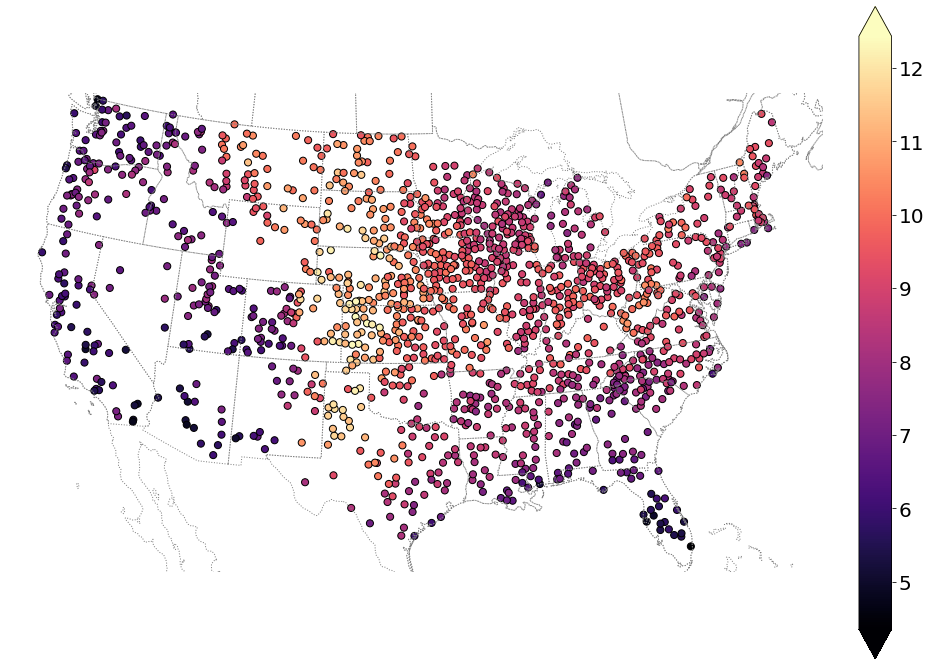

In [23]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

figure = plt.figure(figsize=(16,12))
ax= figure.add_subplot(1,1,1, projection=crs.AlbersEqualArea(central_latitude=39.5, 
                                                             central_longitude=-98.35, globe= None))
ax.axis('off')

ax.add_feature(cfeature.COASTLINE, linestyle=':', edgecolor= 'gray')
ax.add_feature(cfeature.STATES, linestyle=':', edgecolor= 'gray')
# Zoom in on the US by setting longitude/latitude parameters
ax.set_extent([-122, -72, 26, 49],crs=crs.PlateCarree())

plot = plt.scatter(x=data.longitude, y=data.latitude, c=data['mean'], cmap='magma', edgecolors='black'
            ,s= 50,alpha=1,transform=crs.PlateCarree(), vmin= np.min(data['mean']), vmax= np.max(data['mean'])) 

font = {'family':'serif','weight':'bold', 'size': 16}
#plt.title('1950-2019 Mean Volatility for max Tmax in [$\circ$C], n=' + str(len(d)), fontdict= font)

cbar= plt.colorbar(plot,fraction=0.046, pad=0.04, extend= 'both')
cbar.ax.tick_params(labelsize=20) 

plt.savefig('.../Results/Figures/GHCN_Climatology_Volatility95p_1950_2019.jpeg',dpi=600)

plt.show()

## 6: Figure 1b: Seasonality of volatility map

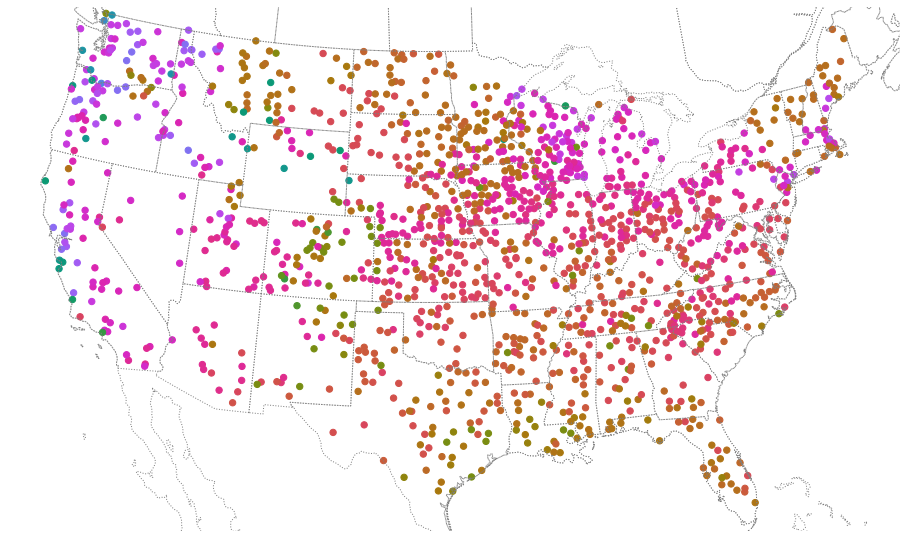

In [170]:
data = pd.read_csv('.../Results/GHCN_julian_day.csv')

from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean

figure = plt.figure(figsize=(16,12))
ax= figure.add_subplot(1,1,1, projection=crs.AlbersEqualArea(central_latitude=39.5, 
                                                             central_longitude=-98.35, globe= None))
ax.axis('off')
ax.add_feature(cfeature.COASTLINE, linestyle=':', edgecolor= 'gray')
ax.add_feature(cfeature.STATES, linestyle=':', edgecolor= 'gray')
# Zoom in on the US by setting longitude/latitude parameters
ax.set_extent([-122, -72, 26, 49],crs=crs.PlateCarree())

plot = plt.scatter(x=data.longitude, y=data.latitude, c=data['julian_day'], transform=crs.PlateCarree(), 
                s= 40, cmap= cmocean.cm.phase)

font = {'family':'serif','weight':'bold', 'size': 16}

#cbar= plt.colorbar(plot,fraction=0.046, pad=0.04)
#plt.title('1950-2019 GHCN-Homogenized Seasonality of Volatility Tmax, n=' + str(data.shape[0]), fontdict= font)


plt.savefig('.../Results/Figures/GHCN_Seasonality_Volatility.jpeg',dpi=600)


plt.show()

<ipython-input-171-0eb375fdbfc3>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(azimuths*np.pi/180.0, zeniths, values, cmap=cmocean.cm.phase)


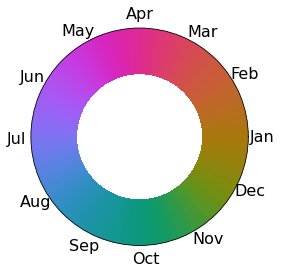

In [171]:
azimuths = np.arange(0, 361, 1)
zeniths = np.arange(40, 70, 1)
values = azimuths * np.ones((30, 361))
fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
ax.pcolormesh(azimuths*np.pi/180.0, zeniths, values, cmap=cmocean.cm.phase)
ax.set_yticks([10, 20, 30])
ax.set_xticks(np.array([0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334])*np.pi/180.0)
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.xticks(fontsize=16)
ax.set_yticklabels(['10', '20', '30'])
ax.tick_params(axis='y', colors='white')

plt.savefig('.../Results/Figures/seasonality_legend.jpeg',
         dpi=600)
    
plt.show()

## 7: Figure 1c: Seasonality of volatility by region

In [206]:
dummy = volatility_abs.iloc[:,1:].groupby(['month','day']).mean()
dummy = dummy[dummy.columns.intersection(volatility_95p.columns)]
dummy.index = list(range(dummy.shape[0]))
dummy = dummy.T
dummy['stationID'] = dummy.index
stations1 = pd.read_csv('.../stationInfo1_1880_2020.csv')
stations2 = pd.read_csv('.../stationInfo2_1880_2020.csv')
stations = pd.concat([stations1, stations2])
stations[stations['stationID'].isin(dummy.index)]
dummy = dummy.merge(stations, on='stationID')

dummy['division'] = 'NaN'
for i in range(len(julian_day)):
    if (dummy.state[i] in ['CT', 'DE', 'ME', 'MD', 'MA', 'NH', 'NJ', 'NY', 'PA', 'RI', 'VT']):
        dummy.division[i] = 'Northeast'
    elif (dummy.state[i] in ['AL', 'FL', 'GA', 'NC', 'SC', 'VA']):
        dummy.division[i] = 'Southeast'
    elif (dummy.state[i] in ['IL', 'IN', 'KY', 'MO', 'OH', 'TN', 'WV']):
        dummy.division[i] = 'Central'
    elif (dummy.state[i] in ['IA', 'MI', 'MN', 'WI']):
        dummy.division[i] = 'Upper Midwest'
    elif (dummy.state[i] in ['AR', 'KS', 'LA', 'MS', 'OK', 'TX']):
        dummy.division[i] = 'South'
    elif (dummy.state[i] in ['MT', 'NE', 'ND', 'SD', 'WY']):
        dummy.division[i] = 'Northern Rockies and Plains'
    elif (dummy.state[i] in ['AZ', 'CO', 'NM', 'UT']):
        dummy.division[i] = 'Southwest'
    elif (dummy.state[i] in ['CA', 'NV']):
        dummy.division[i] = 'West'
    elif (dummy.state[i] in ['ID', 'OR', 'WA']):
        dummy.division[i] = 'Northwest'           
        
data = dummy.groupby(['division']).mean()
data = data.iloc[:,:-3]
data = data.T

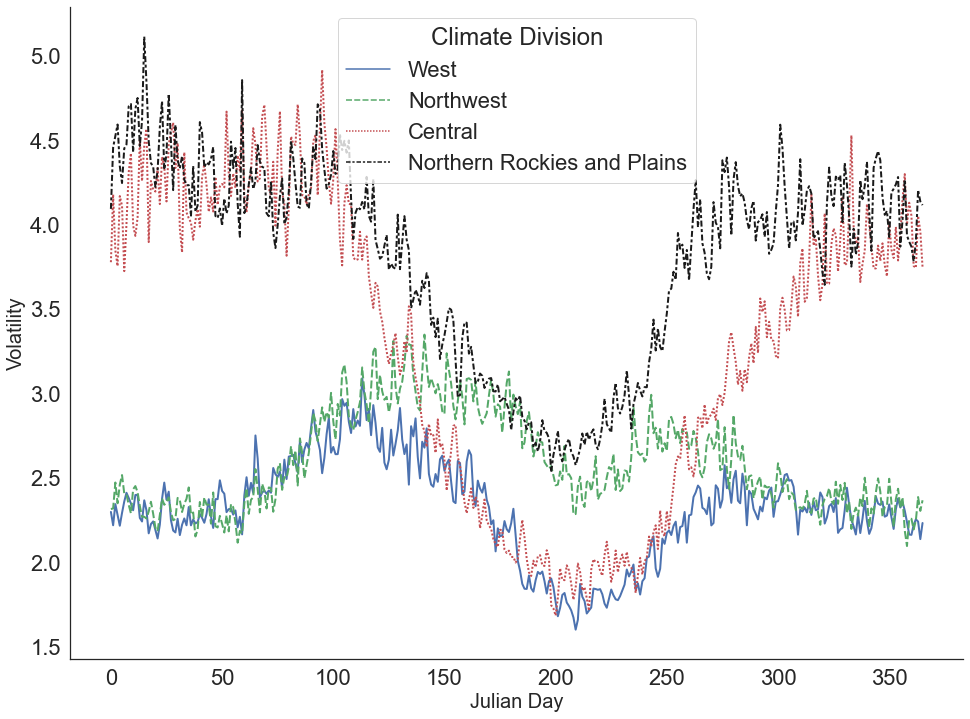

In [211]:
figure = plt.figure(figsize=(16,12))
sns.set(font_scale = 2)
sns.set_style("white")
p = sns.lineplot(data = data[["West", "Northwest", "Central", "Northern Rockies and Plains"]],
                palette=['b', 'g', 'r', 'k'], lw= 2)
p.set_xlabel("Julian Day", fontsize = 20)
p.set_ylabel("Volatility", fontsize = 20)
sns.despine()
plt.legend(loc='upper center', title='Climate Division')
#plt.legend(title='Climate Division', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.savefig('.../Results/Figures/seasonality_by_region.jpeg',
         dpi=600)

## 8: Figure 1d: Directionality of volatility

In [3]:
data = pd.read_csv('.../Results/GHCN_volatility_dir.csv')
data = data.iloc[:,1:]
data = data.T
data['mean'] = np.nan
data['stationID'] = np.nan
data['mean'] = np.nanmean(data.iloc[:,:-2], axis=1)
stations1 = pd.read_csv('.../stationInfo1_1880_2020.csv')
stations2 = pd.read_csv('.../stationInfo2_1880_2020.csv')
stations = pd.concat([stations1, stations2])
stations[stations['stationID'].isin(data.index)]
data['stationID'] = data.index
data = data.merge(stations, on='stationID')
data['mean'] = 1 - data['mean']

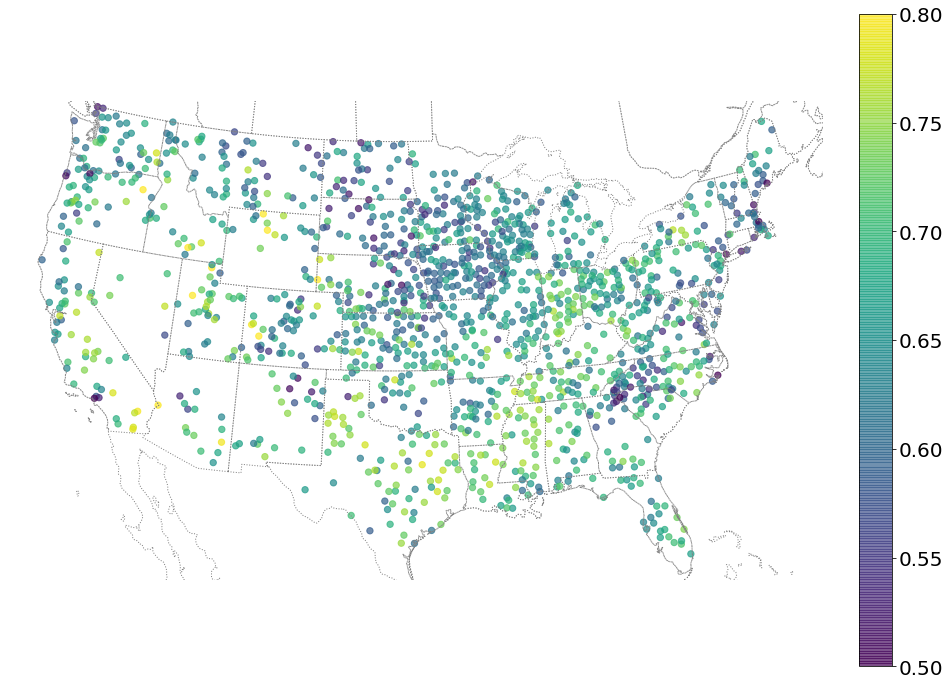

In [4]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

figure = plt.figure(figsize=(16,12))
ax= figure.add_subplot(1,1,1, projection=crs.AlbersEqualArea(central_latitude=39.5, 
                                                             central_longitude=-98.35, globe= None))
ax.axis('off')

ax.add_feature(cfeature.COASTLINE, linestyle=':', edgecolor= 'gray')
ax.add_feature(cfeature.STATES, linestyle=':', edgecolor= 'gray')
# Zoom in on the US by setting longitude/latitude parameters
ax.set_extent([-122, -72, 26, 49],crs=crs.PlateCarree())

plot = plt.scatter(x=data.longitude, y=data.latitude, c= data['mean'], cmap='viridis'
            ,s=40,alpha=0.7,transform=crs.PlateCarree(), vmin= 0.5, vmax= 0.8) 

font = {'family':'serif','weight':'bold', 'size': 16}
#plt.title('1950-2019 Mean Volatility for max Tmax in [$\circ$C], n=' + str(len(d)), fontdict= font)

cbar= plt.colorbar(plot,fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=20) 

plt.savefig('.../Results/Figures/GHCN_Climatology_Volatilitydir_1950_2019.jpeg',dpi=600)

plt.show()

## 9: Trends in Volatility 

In [10]:
data = pd.read_csv('.../Results/GHCN_volatility_95p.csv')
data = data.iloc[:,1:]
data = data.T
tmax_max_trend = pd.DataFrame(index= data.index, columns= ['p-value', 'slope'])
for s in range(data.shape[0]):
    x = data.iloc[s,:]
    if (len(x[~np.isnan(x)]) > 50):
        result = mk.original_test(x)
        tmax_max_trend['p-value'].iloc[s] = result.p
        tmax_max_trend['slope'].iloc[s] = result.slope

In [11]:
tmax_max_trend.to_csv('.../Results/GHCN_trend.csv')

In [26]:
tmax_max_trend = pd.read_csv('.../Results/GHCN_trend.csv')
tmax_max_trend = tmax_max_trend.rename(columns= {'Unnamed: 0': 'stationID'})
stations1 = pd.read_csv('.../stationInfo1_1880_2020.csv')
stations2 = pd.read_csv('.../stationInfo2_1880_2020.csv')
stations = pd.concat([stations1, stations2])
stations[stations['stationID'].isin(tmax_max_trend.index)]
tmax_max_trend = tmax_max_trend.merge(stations, on='stationID')

### 9a: Map of trends (a= 0.05)

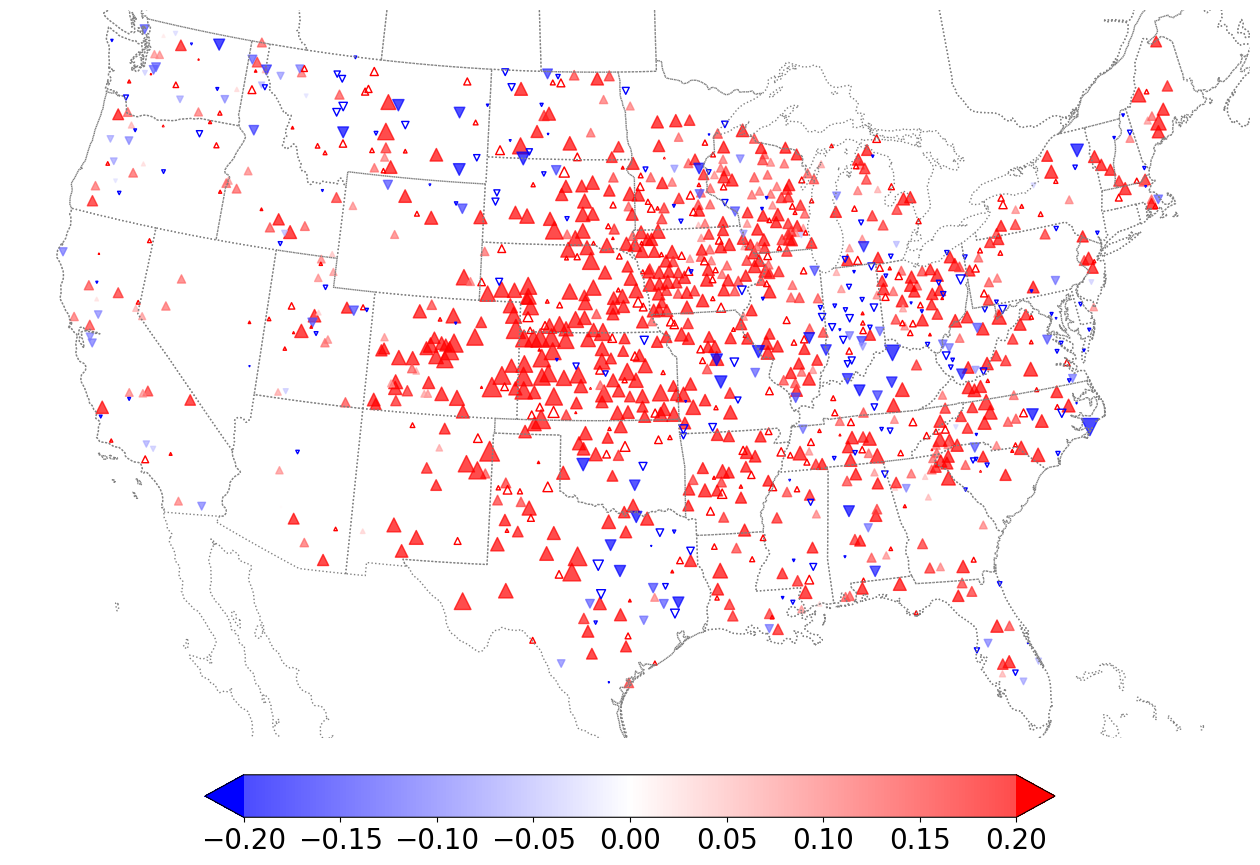

In [41]:
import cartopy
import cartopy.crs as crs
import cartopy.feature as cfeature
%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'

plt.rcParams.update(plt.rcParamsDefault)

figure = plt.figure(figsize=(16,12))
ax= figure.add_subplot(1,1,1, projection=crs.AlbersEqualArea(central_latitude=39.5, 
                                                             central_longitude=-98.35, globe= None))
ax.axis('off')
ax.add_feature(cfeature.COASTLINE, linestyle=':', edgecolor= 'gray')
ax.add_feature(cfeature.STATES, linestyle=':', edgecolor= 'gray')
# Zoom in on the US by setting longitude/latitude parameters
ax.set_extent([-122, -72, 26, 49],crs=crs.PlateCarree())


data = tmax_max_trend

d = data[(data['p-value'] <= 0.05) &  (data['slope'] > 0)]
plot = plt.scatter(x=d.longitude, y=d.latitude, c=d['slope']*10,cmap = 'bwr', transform=crs.PlateCarree(), 
                alpha= 0.7, s= d['slope']*3000, marker= '^', vmin = -0.2, vmax = 0.2)

d = data[(data['p-value'] <= 0.05) &  (data['slope'] < 0)]
plot = plt.scatter(x=d.longitude, y=d.latitude, c=d['slope']*10,cmap = 'bwr', transform=crs.PlateCarree(), 
                alpha= 0.7, s= np.abs(d['slope'])*3000, marker= 'v', vmin = -0.2, vmax = 0.2)

cbar= plt.colorbar(plot,fraction=0.046, pad=0.04, extend= 'both', orientation= 'horizontal')
cbar.ax.tick_params(labelsize=20)


#d = data[(data['p-value'] >= 0.05)]
#plot = plt.scatter(x=d.longitude, y=d.latitude, c='gray', transform=crs.PlateCarree(), 
 #               alpha= 0.2, s= 40, marker= 'o')

d = data[(data['p-value'] > 0.05)  & (data['slope'] > 0)]
plot = plt.scatter(x=d.longitude, y=d.latitude, transform=crs.PlateCarree(), 
                alpha= 1, s= d['slope']*3000, marker= '^', facecolors='none', edgecolors='r')

d = data[(data['p-value'] > 0.05) & (data['slope'] < 0)]
plot = plt.scatter(x=d.longitude, y=d.latitude, transform=crs.PlateCarree(), 
                alpha= 1, s= np.abs(d['slope'])*3000, marker= 'v', facecolors='none', edgecolors='b')

font = {'family':'serif','weight':'bold', 'size': 16}

plt.savefig('.../Results/Figures/GHCN_trend_map.jpeg'
            ,dpi=600)

plt.show()

### Account for multiple hypothesis testing (control FPR)

In [38]:
x = np.sort(tmax_max_trend['p-value'])
y = (np.arange(1, len(x)+1)/len(x))*0.05
alpha_new = max(x[x<y])
alpha_new

0.0235381058384829

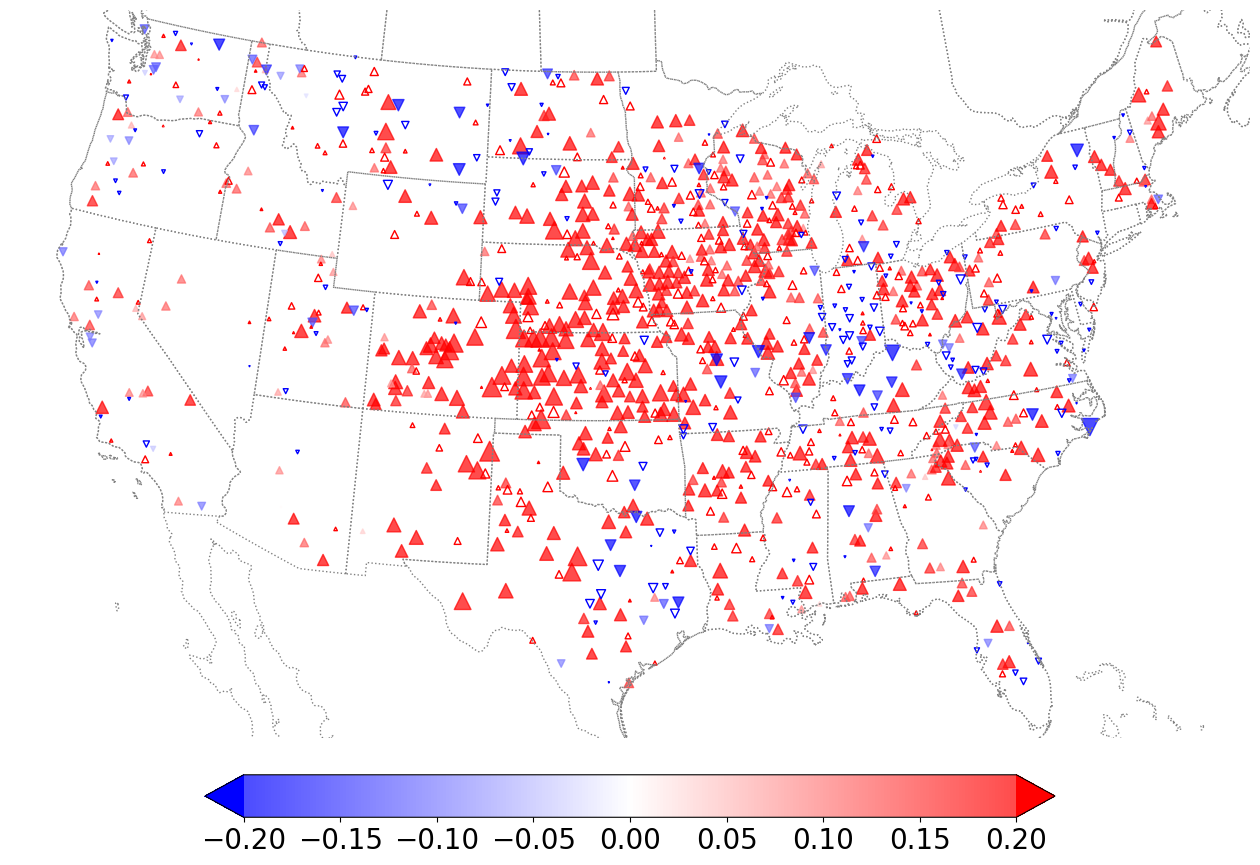

In [40]:
plt.rcParams.update(plt.rcParamsDefault)

figure = plt.figure(figsize=(16,12))
ax= figure.add_subplot(1,1,1, projection=crs.AlbersEqualArea(central_latitude=39.5, 
                                                             central_longitude=-98.35, globe= None))
ax.axis('off')
ax.add_feature(cfeature.COASTLINE, linestyle=':', edgecolor= 'gray')
ax.add_feature(cfeature.STATES, linestyle=':', edgecolor= 'gray')
# Zoom in on the US by setting longitude/latitude parameters
ax.set_extent([-122, -72, 26, 49],crs=crs.PlateCarree())


data = tmax_max_trend

d = data[(data['p-value'] <= alpha_new) &  (data['slope'] > 0)]
plot = plt.scatter(x=d.longitude, y=d.latitude, c=d['slope']*10,cmap = 'bwr', transform=crs.PlateCarree(), 
                alpha= 0.7, s= d['slope']*3000, marker= '^', vmin = -0.2, vmax = 0.2)

d = data[(data['p-value'] <= alpha_new) &  (data['slope'] < 0)]
plot = plt.scatter(x=d.longitude, y=d.latitude, c=d['slope']*10,cmap = 'bwr', transform=crs.PlateCarree(), 
                alpha= 0.7, s= np.abs(d['slope'])*3000, marker= 'v', vmin = -0.2, vmax = 0.2)

cbar= plt.colorbar(plot,fraction=0.046, pad=0.04, extend= 'both', orientation= 'horizontal')
cbar.ax.tick_params(labelsize=20)


#d = data[(data['p-value'] >= 0.05)]
#plot = plt.scatter(x=d.longitude, y=d.latitude, c='gray', transform=crs.PlateCarree(), 
 #               alpha= 0.2, s= 40, marker= 'o')

d = data[(data['p-value'] > alpha_new)  & (data['slope'] > 0)]
plot = plt.scatter(x=d.longitude, y=d.latitude, transform=crs.PlateCarree(), 
                alpha= 1, s= d['slope']*3000, marker= '^', facecolors='none', edgecolors='r')

d = data[(data['p-value'] > alpha_new) & (data['slope'] < 0)]
plot = plt.scatter(x=d.longitude, y=d.latitude, transform=crs.PlateCarree(), 
                alpha= 1, s= np.abs(d['slope'])*3000, marker= 'v', facecolors='none', edgecolors='b')

font = {'family':'serif','weight':'bold', 'size': 16}

plt.savefig('.../Results/Figures/GHCN_trend_map_Sig_FPR.jpeg'
 ,dpi=600)

plt.show()

### 9c: Summary Plots for trends

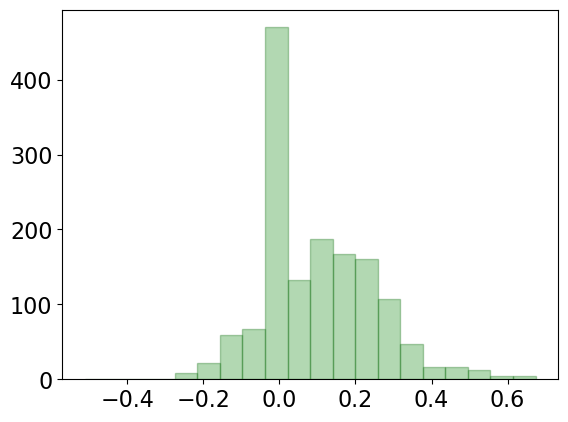

In [303]:
#data = data[(data['p-value'] < 0.05) &  (data['slope'] > 0)]
plt.hist(data['slope']*10, color= 'green',edgecolor= 'darkgreen', alpha= 0.3, bins = 20)
#plt.title('Max Tmax slope [$\circ$C/decade]')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('.../Results/Figures/GHCN_trend_hist.jpeg'
            ,dpi=600)

### 9d: Analysis based on regional climate divisions:

In [280]:
data['division'] = 'NaN'
for i in range(data.shape[0]):
    if (data.state[i] in ['CT', 'DE', 'ME', 'MD', 'MA', 'NH', 'NJ', 'NY', 'PA', 'RI', 'VT']):
        data.division[i] = 'Northeast'
    elif (data.state[i] in ['AL', 'FL', 'GA', 'NC', 'SC', 'VA']):
        data.division[i] = 'Southeast'
    elif (data.state[i] in ['IL', 'IN', 'KY', 'MO', 'OH', 'TN', 'WV']):
        data.division[i] = 'Central'
    elif (data.state[i] in ['IA', 'MI', 'MN', 'WI']):
        data.division[i] = 'Upper Midwest'
    elif (data.state[i] in ['AR', 'KS', 'LA', 'MS', 'OK', 'TX']):
        data.division[i] = 'South'
    elif (data.state[i] in ['MT', 'NE', 'ND', 'SD', 'WY']):
        data.division[i] = 'Northern Rockies and Plains'
    elif (data.state[i] in ['AZ', 'CO', 'NM', 'UT']):
        data.division[i] = 'Southwest'
    elif (data.state[i] in ['CA', 'NV']):
        data.division[i] = 'West'
    elif (data.state[i] in ['ID', 'OR', 'WA']):
        data.division[i] = 'Northwest'                  

In [284]:
divisions = ['Northeast', 'Southeast', 'Central', 'Upper Midwest', 'South', 
             'Northern Rockies and Plains', 'Southwest', 'West', 'Northwest']

regional_results = pd.DataFrame(index= divisions, columns= ['slope', 'percentage', 'n'])

for i in range(len(divisions)):
    x= data[data.division == divisions[i]]
    n= len(x)
    x= x[(x['p-value'] < 0.05) & (x['slope'] > 0)]
    regional_results.slope[i] = np.nanmean(x.slope)
    regional_results.percentage[i] = (len(x)/n)*100
    regional_results.n[i] = n
    
regional_results['area']= [508192, 793100, 817524, 791031, 1488628, 1217333,
                          1099634, 710347, 655903]

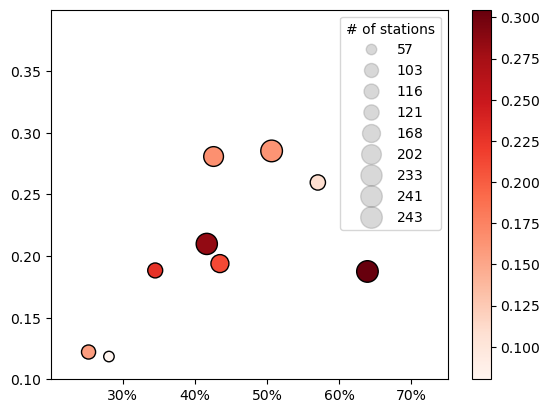

In [301]:
colors = np.random.rand(len(regional_results))
size = list(regional_results.n)
plot= plt.scatter(regional_results.percentage, regional_results.slope*10,  
            s= size, c= (regional_results.n / regional_results.area)*1000, cmap='Reds', edgecolors='black')
#plt.xlabel('% of stations with a statistically significant increasing trend', fontsize=18)
#plt.ylabel('C / Decade', fontsize=18)

plt.xticks([30, 40, 50, 60, 70], ['30%', '40%', '50%', '60%', '70%'])
plt.yticks([0.1, 0.15, 0.2, 0.25, 0.3, 0.35], ['0.10', '0.15', '0.20', '0.25', '0.30', '0.35'])


#for i in range(len(divisions)):
 #   plt.annotate(divisions[i], (regional_results.percentage[i], regional_results.slope[i]*10 + 0.01), c= 'gray', size= 10)
    
plt.ylim([0.1, 0.4])
plt.xlim([20, 75])
plt.colorbar()

handles, labels = plot.legend_elements(prop="sizes", alpha=0.3, color= 'gray')
plt.legend(handles, labels, loc="upper right", title="# of stations")

plt.savefig('.../Results/Figures/GHCN_trend_regional.jpeg'
            ,dpi=600)

plt.show()

In [302]:
regional_results

,slope,percentage,n,area
Northeast,0.018835,34.482759,116,508192
Southeast,0.01939,43.452381,168,793100
Central,0.020987,41.630901,233,817524
Upper Midwest,0.018751,63.900415,241,791031
South,0.028535,50.617284,243,1488628
Northern Rockies and Plains,0.028081,42.574257,202,1217333
Southwest,0.025975,57.024793,121,1099634
West,0.011846,28.070175,57,710347
Northwest,0.012213,25.242718,103,655903
